### 相关性分析:公园总面积与其他相关因素的关系

#### 公园分析相关的影响因素

公园的可达性
- 公园到附近的自行车网络的最短距离
- 公园到附近的metro车站的最短距离
- 公园步行范围内的metro车站数目

公园周围环境的特征
- 公园附近的公立学校数目 （居民）
- 公园附近的住宅数目
- 公园附近的廉租房数目
- 公园附近其他的landmarks数目 （visitor）
- 公园附近的公司数目（通过就业人口来决定） (employer)

公园周围人口的特征
- 公园附近的老年人比例
- 公园附近的年轻人比例
- 公园最近5个邻近公园的平均人口密度

In [1]:
from shapely.geometry import box

In [2]:
import matplotlib.pyplot as plt

In [3]:
from contextily import add_basemap

In [4]:
import contextily as cx

In [5]:
from shapely.geometry import Point, Polygon

In [6]:
from shapely.ops import transform

In [7]:
from pyproj import Transformer

In [8]:
import geopandas as gpd

In [9]:
import numpy as np

In [10]:
import time

In [11]:
import requests

In [12]:
import pandas as pd

In [13]:
projected_crs = '3857' # web mercator

In [14]:
parks_with_amenities = pd.read_csv('park_related_properties.csv')
parks_with_demographic = pd.read_csv('parks_isochrones_with_demographic.csv')

parks_with_info = pd.merge(parks_with_amenities, parks_with_demographic, on = 'OBJECTID', how = 'outer')
parks_with_info.head()

,Unnamed: 0_x,OBJECTID,isochrones_x,centroid_x,Schools_count,Landmarks_count,Metros_count,Housings_count,Affordable_Housings_count,job_count,...,distance_to_nearest_bike_network,Unnamed: 0_y,isochrones_y,centroid_y,POP_DENSITY,EMPLOYED_PERCENTAGE,UNDER5_PERCENTAGE,65_PERCENTAGE,PEOPLE_OF_COLOR_PERCENTAGE,POVERTY_PERCENTAGE
0,0,658736,"POLYGON ((-13620700 6057390, -13620800 6057360...",POINT (-13614900 6048020),0,0,66,30,20,0,...,13.528561,2087,"POLYGON ((-13613275.445921 6030004.852997, -13...",POINT (-13614889.524478 6048020.708636),1522.478027,42.754918,6.827808,16.458388,85.544739,21.586115
1,1,658737,"POLYGON ((-13622400 6036770, -13622600 6036870...",POINT (-13611600 6052440),0,0,30,0,1,0,...,29.330247,2189,"POLYGON ((-13611845.99234 6028495.611318, -136...",POINT (-13611635.960618 6052435.229062),1155.846725,45.255925,6.406198,14.604505,72.800813,13.735435
2,2,658738,"POLYGON ((-13625600 6048770, -13626000 6048240...",POINT (-13613800 6060200),1,3,50,0,5,0,...,14.313898,2162,"POLYGON ((-13623893.321592 6040007.393147, -13...",POINT (-13613848.548785 6060204.356927),251.878742,60.314961,2.047244,21.732283,23.464567,5.905512
3,3,658739,"POLYGON ((-13624100 6057330, -13624300 6057170...",POINT (-13615500 6042810),1,0,48,6,2,0,...,39.834804,1793,"POLYGON ((-13612982.007743 6028715.534663, -13...",POINT (-13615537.64542 6042812.635743),630.883997,44.339802,8.303917,20.234221,86.156874,27.319822
4,4,658740,"POLYGON ((-13613600 6039830, -13614000 6039370...",POINT (-13621200 6051950),0,0,116,47,10,0,...,17.301565,2605,"POLYGON ((-13621400.432915 6032129.680003, -13...",POINT (-13621169.499321 6051948.838358),1155.721813,54.135188,8.463609,8.396390,62.947980,12.523368


In [15]:
# delete some columns
parks_with_info = parks_with_info.drop(columns = ['Unnamed: 0_x','Unnamed: 0_y','isochrones_x','centroid_x','isochrones_y','centroid_y'])

In [16]:
parks_detail = gpd.read_file('park_details_isochrones_10_walking_gdf.geojson')
parks_detail = parks_detail.to_crs(epsg = projected_crs)
parks_detail.columns

Index(['OBJECTID', 'NAME', 'PMA_NAME', 'ADDRESS', 'PIN', 'SUBPARCEL',
       'TOTAL_AREA', 'OWNER', 'LEASE', 'MAINT', 'TYPE', 'ACQ_DATE', 'NAMEFLAG',
       'REVIEW_DATE', 'AMWOID', 'SDQL', 'SE_ANNO_CAD_DATA', 'GIS_CRT_DT',
       'GIS_EDT_DT', 'GlobalID', 'centroid', 'isochrones', 'geometry'],
      dtype='object')

In [17]:
parks_detail['TYPE']

0       PK
1       PK
2       PK
3       PK
4       PK
        ..
2664    PK
2665    PK
2666    PK
2667    PF
2668    PK
Name: TYPE, Length: 2669, dtype: object

In [18]:
park_types = parks_detail['TYPE'].unique()
park_types

array(['PK', 'GB', 'PL', 'PG', None, 'PP', 'GN', 'PF', 'TS', 'SP', 'VP',
       'BV', 'GF', 'MT', 'BL', 'CS', 'CC', 'TR', 'LE'], dtype=object)

In [19]:
# 这里略复杂,反复推导

In [20]:
# 创建一个字典来定义多个值的映射
value_mapping = {
    park_type:(index if park_type is not None else -1) for index,park_type in enumerate(park_types,start = 1)
}
# enumerate(park_types, start=1)：enumerate 是 Python 的内置函数，用于将一个可迭代对象（这里是 park_types）组合为一个索引序列，同时列出数据和数据下标。
# start=1 表示索引从 1 开始，而不是默认的 0。

# 使用 map() 方法替换列中的值
parks_detail['TYPE'] = parks_detail['TYPE'].map(value_mapping)
parks_detail['TYPE'].head()

0    1
1    1
2    1
3    1
4    1
Name: TYPE, dtype: int64

In [21]:
merged_parks_gdf = parks_detail.merge(parks_with_info,on = 'OBJECTID')
merged_parks_gdf.columns

Index(['OBJECTID', 'NAME', 'PMA_NAME', 'ADDRESS', 'PIN', 'SUBPARCEL',
       'TOTAL_AREA', 'OWNER', 'LEASE', 'MAINT', 'TYPE', 'ACQ_DATE', 'NAMEFLAG',
       'REVIEW_DATE', 'AMWOID', 'SDQL', 'SE_ANNO_CAD_DATA', 'GIS_CRT_DT',
       'GIS_EDT_DT', 'GlobalID', 'centroid', 'isochrones', 'geometry',
       'Schools_count', 'Landmarks_count', 'Metros_count', 'Housings_count',
       'Affordable_Housings_count', 'job_count',
       'nearest_residential_distance', 'nearest_MHA_distance',
       'nearest_metro_distance', 'nearest_school_distance',
       'nearest_landmark_distance', 'nearest_park_distance',
       'distance_to_nearest_bike_network', 'POP_DENSITY',
       'EMPLOYED_PERCENTAGE', 'UNDER5_PERCENTAGE', '65_PERCENTAGE',
       'PEOPLE_OF_COLOR_PERCENTAGE', 'POVERTY_PERCENTAGE'],
      dtype='object')

In [22]:
merged_parks_gdf.to_csv('park_information_all.csv')

In [23]:
merged_parks_gdf.head()

,OBJECTID,NAME,PMA_NAME,ADDRESS,PIN,SUBPARCEL,TOTAL_AREA,OWNER,LEASE,MAINT,...,nearest_school_distance,nearest_landmark_distance,nearest_park_distance,distance_to_nearest_bike_network,POP_DENSITY,EMPLOYED_PERCENTAGE,UNDER5_PERCENTAGE,65_PERCENTAGE,PEOPLE_OF_COLOR_PERCENTAGE,POVERTY_PERCENTAGE
0,660345,SEOLA PARK,Seola Park,,7110000066,22024.0,466,DPR,N,DPR,...,3452.078700,4496.596161,6.523181,16.803735,1340.473015,53.224039,7.445560,14.533173,28.095383,8.705330
1,659362,SEOLA PARK,Seola Park,,1123039030,9627.0,466,DPR,N,DPR,...,3419.786172,4468.062235,9.128640,95.845727,1090.873153,55.335690,5.004556,13.980434,21.342277,2.651710
2,659360,SEOLA PARK,Seola Park,,1223039013,9627.0,466,DPR,N,DPR,...,3361.940206,4409.443064,50.796062,84.319267,748.194085,51.364259,3.178540,20.553536,72.919848,7.432395
3,660174,SEOLA PARK,Seola Park,None,None,9627.0,466,DPR,N,DPR,...,3351.203768,4401.806958,6.525327,148.302319,1138.385089,44.467581,6.452216,15.853316,75.931649,15.587020
4,659359,SEOLA PARK,Seola Park,,1123039028,9628.0,466,DPR,N,DPR,...,3352.688184,4406.373465,22.683068,128.920052,187.901788,66.224703,4.815073,11.304955,29.867411,5.094208


In [24]:
# 选择需要分析的列
selected_columns = [
    'TOTAL_AREA','TYPE',
    'Schools_count', 'Landmarks_count',
    'Metros_count', 'Housings_count', 'Affordable_Housings_count',
    'job_count', 'nearest_residential_distance', 'nearest_MHA_distance',
    'nearest_metro_distance', 'nearest_school_distance',
    'nearest_landmark_distance', 'nearest_park_distance',
    'distance_to_nearest_bike_network', 'POP_DENSITY',
    'EMPLOYED_PERCENTAGE', 'UNDER5_PERCENTAGE', '65_PERCENTAGE',
    'PEOPLE_OF_COLOR_PERCENTAGE', 'POVERTY_PERCENTAGE'
]

# 筛选 DataFrame 中的所选列
correlation_data = merged_parks_gdf[selected_columns]
correlation_data.head()

,TOTAL_AREA,TYPE,Schools_count,Landmarks_count,Metros_count,Housings_count,Affordable_Housings_count,job_count,nearest_residential_distance,nearest_MHA_distance,...,nearest_school_distance,nearest_landmark_distance,nearest_park_distance,distance_to_nearest_bike_network,POP_DENSITY,EMPLOYED_PERCENTAGE,UNDER5_PERCENTAGE,65_PERCENTAGE,PEOPLE_OF_COLOR_PERCENTAGE,POVERTY_PERCENTAGE
0,466,1,0,0,30,7,2,0,145.193647,787.227439,...,3452.078700,4496.596161,6.523181,16.803735,1340.473015,53.224039,7.445560,14.533173,28.095383,8.705330
1,466,1,0,0,146,0,2,12217,73.560633,736.856488,...,3419.786172,4468.062235,9.128640,95.845727,1090.873153,55.335690,5.004556,13.980434,21.342277,2.651710
2,466,1,1,0,12,15,0,0,120.894888,684.849126,...,3361.940206,4409.443064,50.796062,84.319267,748.194085,51.364259,3.178540,20.553536,72.919848,7.432395
3,466,1,2,0,88,27,33,0,97.815151,659.453271,...,3351.203768,4401.806958,6.525327,148.302319,1138.385089,44.467581,6.452216,15.853316,75.931649,15.587020
4,466,1,3,0,166,141,51,935,112.178215,646.554081,...,3352.688184,4406.373465,22.683068,128.920052,187.901788,66.224703,4.815073,11.304955,29.867411,5.094208


In [25]:
# 对所有列应用pd.to_numeric(),将无法转换的值设为NaN
# pd.to_numeric() 是 Pandas 库中的一个函数，用于将对象数据（如字符串）转换为数值类型（如整数或浮点数）
correlation_data = correlation_data.apply(pd.to_numeric,errors = 'coerce')
# errors='coerce' 表示当遇到无法转换为数值的值时，将这些值强制转换为 NaN（缺失值）

# 使用fillna()将NaN替换为0
correlation_data = correlation_data.fillna(0)

In [27]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [38]:
# 研究的是各种因素和TotalArea的关系

In [31]:
# 将 DataFrame 转换为长格式
correlation_long = correlation_data.melt(id_vars = ['TOTAL_AREA'],var_name = 'Variable',value_name = 'Value')
# pd.melt(df, id_vars = ['不要被转换的列'], var_name = '包含原本列名值的新列的列名', value_name = '包含原本数据值的新列的列名')
correlation_long.head()

,TOTAL_AREA,Variable,Value
0,466,TYPE,1.0
1,466,TYPE,1.0
2,466,TYPE,1.0
3,466,TYPE,1.0
4,466,TYPE,1.0


In [32]:
# 检查是否存在非数值数据并进行转换
correlation_long['Value'] = pd.to_numeric(correlation_long['Value'],errors = 'coerce')
# 删除转换为NaN值的行
correlation_long.dropna(subset = ['Value'])

,TOTAL_AREA,Variable,Value
0,466,TYPE,1.000000
1,466,TYPE,1.000000
2,466,TYPE,1.000000
3,466,TYPE,1.000000
4,466,TYPE,1.000000
...,...,...,...
53375,4408,POVERTY_PERCENTAGE,15.649333
53376,4408,POVERTY_PERCENTAGE,10.736594
53377,4408,POVERTY_PERCENTAGE,6.613880
53378,288,POVERTY_PERCENTAGE,6.234740


In [43]:
# 归类 - 计算totalarea和其他系数的关系

In [44]:
# numeric_df.corr().iloc[0,1] 还是不是太懂

In [26]:
# 计算相关系数
def calculate_correlation(df):
    # 保留数值型列进行相关系数计算
    numeric_df = df.select_dtypes(include = 'number')
    if numeric_df.shape[1]>1: # 确保至少有两个数值型列
        return numeric_df.corr().iloc[0,1] # 计算相关系数
    else:
        return None

In [37]:
# 计算相关性系数
correlation_cor = correlation_long.groupby('Variable').apply(calculate_correlation).reset_index()
correlation_cor.columns = ['Variable', 'correlation']

correlation_cor

/var/folders/hx/vrwsgqgx7bncbt28n44f0b540000gn/T/ipykernel_9686/1988342346.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  correlation_cor = correlation_long.groupby('Variable').apply(calculate_correlation).reset_index()


,Variable,correlation
0,65_PERCENTAGE,-0.001652
1,Affordable_Housings_count,0.016567
2,EMPLOYED_PERCENTAGE,0.009121
3,Housings_count,0.012092
4,Landmarks_count,0.014620
5,Metros_count,0.001852
6,PEOPLE_OF_COLOR_PERCENTAGE,0.029020
7,POP_DENSITY,0.029781
8,POVERTY_PERCENTAGE,0.016359
9,Schools_count,0.008265


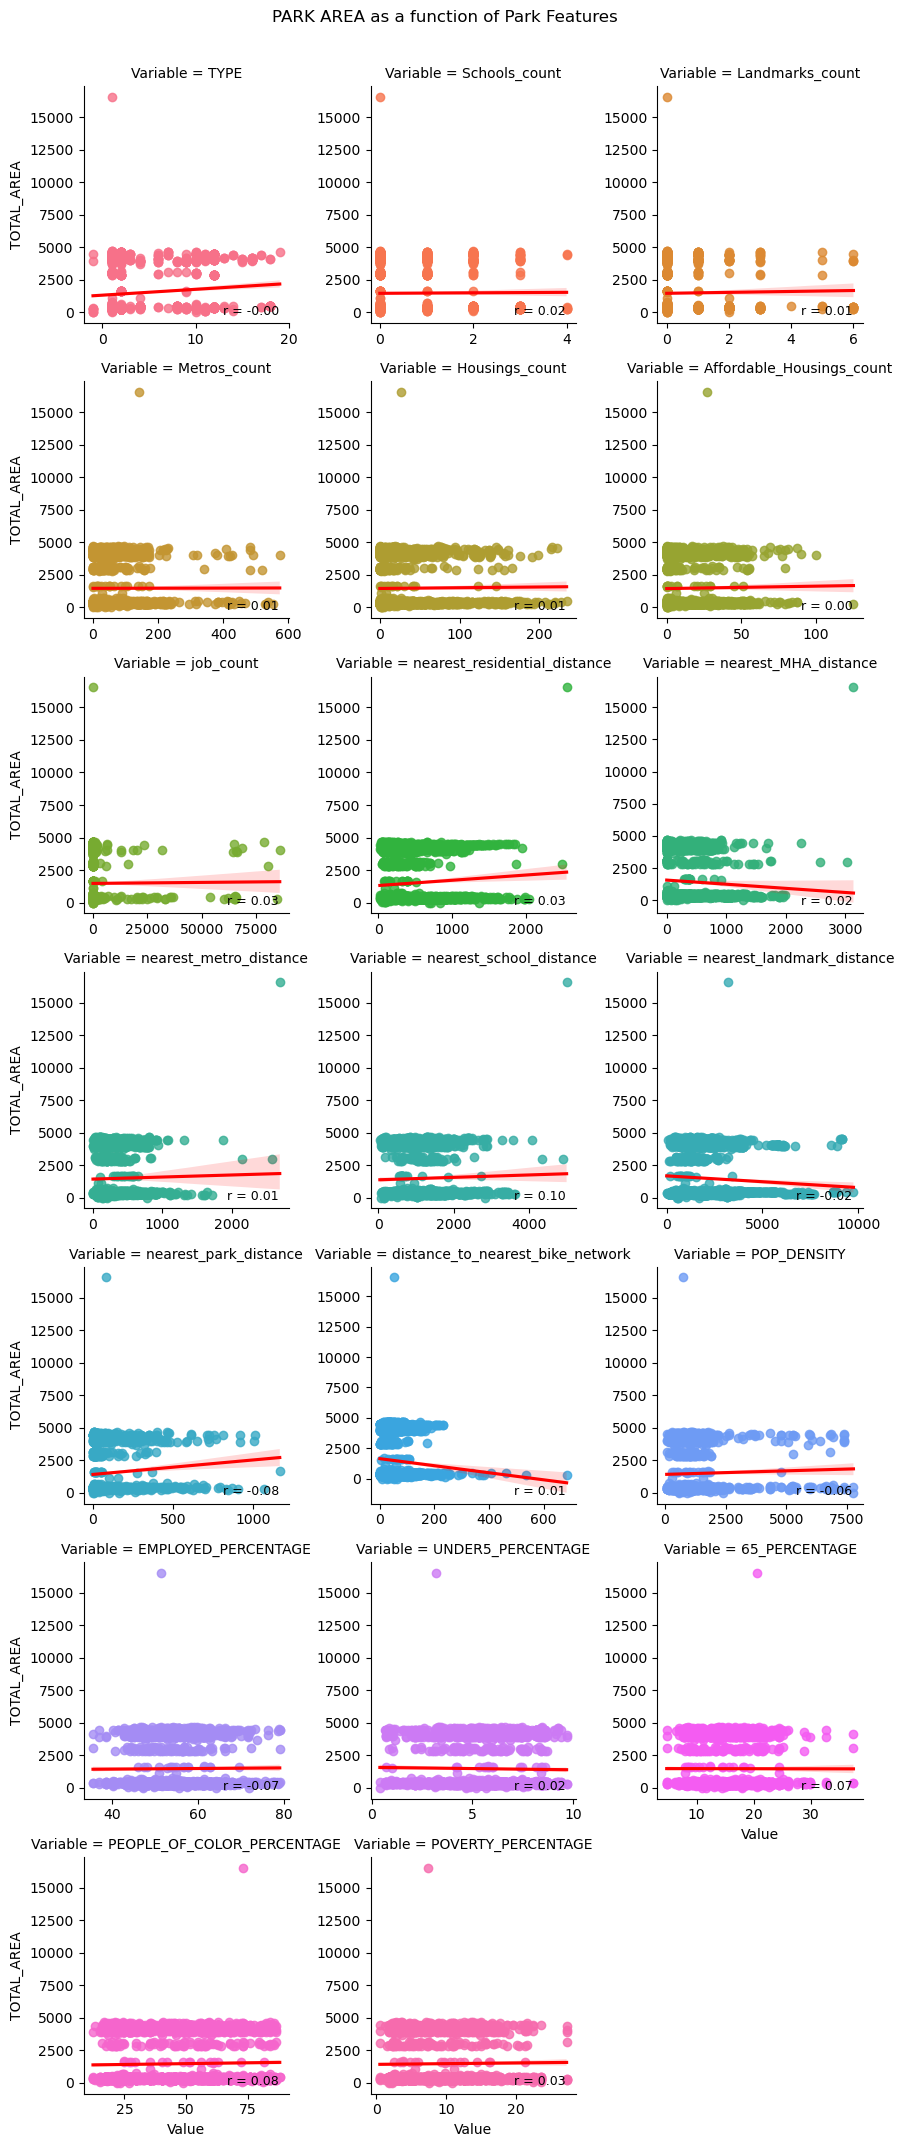

In [42]:
# 绘制相关性图
g = sns.FacetGrid(correlation_long, col="Variable", col_wrap=3, hue = 'Variable', sharex=False, sharey=False)
g.map_dataframe(sns.regplot, x='Value', y='TOTAL_AREA', line_kws={"color": "red"})
g.set_axis_labels("Value", "TOTAL_AREA")
g.fig.suptitle("PARK AREA as a function of Park Features", y=1.02)

# 注释相关系数
for ax, label in zip(g.axes.flat, correlation_cor['correlation']):
    ax.text(0.95, 0.05, f'r = {label:.2f}', transform=ax.transAxes, ha='right', va='center', size=9)

plt.show()